In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import core
from core import Region, NPerson, EP

# 用途分解の計算

## 1. 概要

本ファイルは、用途分解の計算方法について記しています。  
ここで用途分解とは、家庭におけるエネルギー種別ごとの消費量つまり、消費電力、ガス消費量、灯油消費量から、家庭における用途別エネルギー消費量を推計する方法を言います。  
用途は、暖房・冷房・換気・給湯・照明・家電・調理に分類されます。
消費電力、ガス消費量、および灯油消費量は、領収書などから月単位で把握できているものとします。  
エネルギー種別の単位は以下のとおりです。  
- 消費電力  kwh
- ガス消費量  m<sup>3</sup>
- 灯油消費量  L

用途別エネルギーの推計は、エネルギー種別ごとに行います。  
電力を消費する用途としては、全ての用途が考えられます。  
ガスを消費する用途としては、暖房・給湯・調理が考えられます。  
灯油を消費する用途としては、暖房・給湯が考えられます。

用途が1つに限られている場合、例えば、灯油を暖房にしか使用していない場合などは、用途分解をするまでもなく用途が決定します。  
用途が複数にわたる場合、例えば、灯油を暖房と給湯に使用している場合などは、暖房は冬期にしか使用しないことから、灯油消費量の月別の推移を見ておおよそ暖房と給湯に分解します。  
電力の用途分解は非常に難しく、例えば電力を換気と照明に分類する場合、換気も照明も季節的な変動が見られないため、用途を分解するのは困難です。本方法では、一般的な家庭を想定した結果をデフォルト値として示しますので、家庭の事情（例えば日中照明を良く使っているなど）をヒアリングして、消費量を修正してください。

## 結果の描画

### 1) グラフ

In [2]:
def plot_fig(htg, clg, hws, vnt, lgt, eap, ckg):
    
    y_htg = np.array(htg)
    y_clg = np.array(clg)
    y_hws = np.array(hws)
    y_vnt = np.array(vnt)
    y_lgt = np.array(lgt)
    y_eap = np.array(eap)
    y_ckg = np.array(ckg)
    
    figure, ax  = plt.subplots(1,1,figsize=(15,8))
    x = range(12)
    
    ax.bar(x, y_ckg, color='k', width=0.9, label='cooking')
    ax.bar(x, y_eap, color='g', width=0.9, label='electric appliances', bottom = y_ckg)
    ax.bar(x, y_lgt, color='y', width=0.9, label='lighting', bottom = y_ckg+y_eap)
    ax.bar(x, y_vnt, color='c', width=0.9, label='ventilation', bottom = y_ckg+y_eap+y_lgt)
    ax.bar(x, y_hws, color='m', width=0.9, label='how water supply', bottom = y_ckg+y_eap+y_lgt+y_vnt)
    ax.bar(x, y_clg, color='b', width=0.9, label='cooling', bottom = y_ckg+y_eap+y_lgt+y_vnt+y_hws)
    ax.bar(x, y_htg, color='r', width=0.9, label='heating', bottom = y_ckg+y_eap+y_lgt+y_vnt+y_hws+y_clg)
    
    ax.set_xticks(range(12))
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jly','Aug','Sep','Otc','Nov','Dec'])
    ax.legend()
    plt.show()

### 2) 表

In [3]:
def plot_table(htg, clg, hws, vnt, lgt, eap, ckg, consumption):
    df = pd.DataFrame({'暖房': list(map(int, htg)),
                       '冷房': list(map(int, clg)),
                       '給湯': list(map(int, hws)),
                       '換気': list(map(int, vnt)),
                       '照明': list(map(int, lgt)),
                       '家電': list(map(int, eap)),
                       '調理': list(map(int, ckg)),
                       '分解前': list(map(int, consumption))},
                       index=['Jan','Feb','Mar','Apr','May','Jun','Jly','Aug','Sep','Otc','Nov','Dec'])
    return df.T

## 14. 最終的な関数

In [4]:
def analysis(d):

    general = d['general']
    region = core.Region(general['region'])
    p = core.NPerson(general['number_of_people'])
    a_mr = float(general['main_habitable_room_floor_area'])
    a_or = float(general['other_habitable_room_floor_area'])
    a_a = float(general['total_floor_area'])
    u_e = bool(general['electric_use'])
    u_g = bool(general['gas_use'])
    u_k = bool(general['kerosene_use'])

    if u_e:
        electricity = d['electricity']
        s_e_m = electricity['consumption']
        u_e_h_m = electricity['heating']['use']
        u_e_c_m = electricity['cooling']['use']
        u_e_v = bool(electricity['ventilation']['use'])
        c_e_v = float(electricity['ventilation']['coeff']) if u_e_v else None
        u_e_hw = bool(electricity['hot_water_supply']['use'])
        c_e_hw = float(electricity['hot_water_supply']['coeff']) if u_e_hw else None
        u_e_l = bool(electricity['lighting']['use'])
        c_e_l = float(electricity['lighting']['coeff']) if u_e_l else None
        u_e_ap = bool(electricity['electric_appliance']['use'])
        c_e_ap = float(electricity['electric_appliance']['coeff']) if u_e_ap else None
        u_e_cc = bool(electricity['cooking']['use'])
        c_e_cc = float(electricity['cooking']['coeff']) if u_e_cc else None
        f_pe_e_default = True
        f_pe_e = None
    else:
        s_e_m = None
        u_e_h_m = None
        u_e_c_m = None
        u_e_v = None
        c_e_v = None
        u_e_hw = None
        c_e_hw = None
        u_e_l = None
        c_e_l = None
        u_e_ap = None
        c_e_ap = None
        u_e_cc = None
        c_e_cc = None
        f_pe_e_default = None
        f_pe_e = None

    if u_g:
        gas = d['gas']
        s_g_m = gas['consumption']
        u_g_h_m = gas['heating']['use']
        u_g_hw = bool(gas['hot_water_supply']['use'])
        c_g_hw = float(gas['hot_water_supply']['coeff']) if u_g_hw else None
        u_g_cc = bool(gas['cooking']['use'])
        c_g_cc = float(gas['cooking']['coeff']) if u_g_cc else None
        f_pe_g_default = True
        gas_type = 'city_gas'
        f_pe_g = None
    else:
        s_g_m = None
        u_g_h_m = None
        u_g_hw = None
        c_g_hw = None
        u_g_cc = None
        c_g_cc = None
        f_pe_g_default = True
        gas_type = None
        f_pe_g = None

    if u_k:
        kerosene = d['kerosene']
        s_k_m = kerosene['consumption']
        u_k_h_m = kerosene['heating']['use']
        u_k_hw = bool(kerosene['hot_water_supply']['use'])
        c_k_hw = float(kerosene['hot_water_supply']['coeff']) if u_k_hw else None
        f_pe_k_default = True
        f_pe_k = None
    else:
        s_k_m = None
        u_k_h_m = None
        u_k_hw = None
        c_k_hw = None
        f_pe_k_default = None
        f_pe_k = None

    e_p_e, e_p_g, e_p_k, e_p = core.kernel(
        region=region, p=p, a_mr=a_mr, a_or=a_or, a_a=a_a, u_e=u_e, u_g=u_g, u_k=u_k,
        s_e_m=s_e_m, u_e_h_m=u_e_h_m, u_e_c_m=u_e_c_m, u_e_v=u_e_v, c_e_v=c_e_v, u_e_hw=u_e_hw, c_e_hw=c_e_hw, u_e_l=u_e_l, c_e_l=c_e_l, u_e_ap=u_e_ap, c_e_ap=c_e_ap, u_e_cc=u_e_cc, c_e_cc=c_e_cc, f_pe_e_default=f_pe_e_default, f_pe_e=f_pe_e,
        s_g_m=s_g_m, u_g_h_m=u_g_h_m, u_g_hw=u_g_hw, c_g_hw=c_g_hw, u_g_cc=u_g_cc, c_g_cc=c_g_cc, f_pe_g_default=f_pe_g_default, gas_type=gas_type, f_pe_g=f_pe_g,
        s_k_m=s_k_m, u_k_h_m=u_k_h_m, u_k_hw=u_k_hw, c_k_hw=c_k_hw, f_pe_k_default=f_pe_k_default, f_pe_k=f_pe_k
    )

    if u_e:
        return e_p_e.h_m, e_p_e.c_m, e_p_e.v_m, e_p_e.l_m, e_p_e.hw_m, e_p_e.ap_m, e_p_e.cc_m
    if u_g:
        return e_p_g.h_m, e_p_g.c_m, e_p_g.v_m, e_p_g.l_m, e_p_g.hw_m, e_p_g.ap_m, e_p_g.cc_m
    if u_k:
        return e_p_k.h_m, e_p_k.c_m, e_p_k.v_m, e_p_k.l_m, e_p_k.hw_m, e_p_k.ap_m, e_p_k.cc_m
    else:
        raise Exception()



In [5]:
def analysis_and_plot(d):
    htg, clg, vnt, lgt, hws, eap, ckg = analysis(d)
    plot_fig(htg, clg, hws, vnt, lgt, eap, ckg)
    general = d['general']
    u_e = bool(general['electric_use'])
    u_g = bool(general['gas_use'])
    u_k = bool(general['kerosene_use'])
    if u_e:
        consumption = d['electricity']['consumption']
    elif u_g:
        consumption = d['gas']['consumption']
    elif u_k:
        consumption = d['kerosene']['consumption']
    else:
        raise Exception()

    print(plot_table(htg, clg, hws, vnt, lgt, eap, ckg, consumption))

## 15. 使用例

### 15.1 入力データ

#### 1) 全体

辞書型データのKeyとして、  

- general
- consumption
- heating
- cooling
- ventilation
- hot_water_supply
- lighting
- electric_appliance
- cooking

を持ちます。

#### 2) general

'general'はさらに、

- number_of_people
- main_habitable_room_floor_area
- other_habitale_room_floor_area
- total_floor_area

を持ちます。

'number_of_people': 世帯の人数です。1～4人の数字を入力します。5人以上の計算には対応していないため、その場合は4人として推計してください。  
'main_habitable_room_floor_area': 主たる居室の床面積(m2)です。  
'othera_habitable_room_floor_area': その他の居室の床面積(m2)です。  
'total_floor_area': 述べ床面積(m2)です。  
主たる居室の床面積とその他の居室の床面積の合計が、述べ床面積を超えないようにしてください。

```
'general' : {
    'number_of_people' : 4,
    'main_habitable_room_floor_area' : 29.81,
    'other_habitable_room_floor_area' : 54.34,
    'total_floor_area' : 120.08,
}
```

#### 3) consumption

'consumption'は月ごとのエネルギー消費量であり、電力の場合はkWhまたはMJ、ガスの場合はm3またはMJ、灯油の場合はLまたはMJで入力します。月ごとの値はリストで指定します。リストの長さは必ず12でないといけません。

```
'consumption' : [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
```

#### 4) heating

'heating'はさらに、

- use

を持ちます。

'use'は暖房の使用月であり、長さ12のリストで指定します。暖房を使用している場合は、Trueを、使用していない場合は、Falseを指定します。

```
'heating' : {
    'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
}
```

#### 5) cooling

'cooling'はさらに、

- use

を持ちます。

'use'は暖房の使用月であり、長さ12のリストで指定します。暖房を使用している場合は、Trueを、使用していない場合は、Falseを指定します。

```
'cooling' : {
    'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
}
```

#### 6) ventilation / hot_water_supply / lighting / electric_appliance / cooking

'ventilation' 'ventilation' 'hot_water_supply' 'lighting' 'electric_appliance' 'cooking' それぞれ、はさらに、

- use
- coef

を持ちます。

'use'は、その用途にエネルギーが使われているかを指定します。True / False で指定します。Falsew を指定した場合は、'coef'の値は無視されます。  
'coef'は、調整係数を表します。調整係数とは、本計算方法によって計算された分解後の用途別給湯消費量を調整する役割を表しています。係数=1.0の場合は調整なしです。係数を1.0より大きくすると、該当する用途の消費量が増え、代わりにその他の用途の消費量が減ります。係数を1.0より小さくすると、該当する用途の消費量が減り、代わりにその他の用途の消費量が増えます。使用実態や居住者へのヒアリング結果などを踏まえて、係数の調整をしてください。係数の調整の仕方がわからない場合は、デフォルト値の1.0としておいてください。

```
'ventilation' : { 'use' : True, 'coeff' : 1.0 },
'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
'lighting' : { 'use' : True, 'coeff' : 1.0 },
'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
'cooking' : { 'use' : True, 'coeff' : 1.0 }
```

### 15.2 計算例

給湯を除く暖冷房・換気・照明・家電・調理に電力を使用する場合

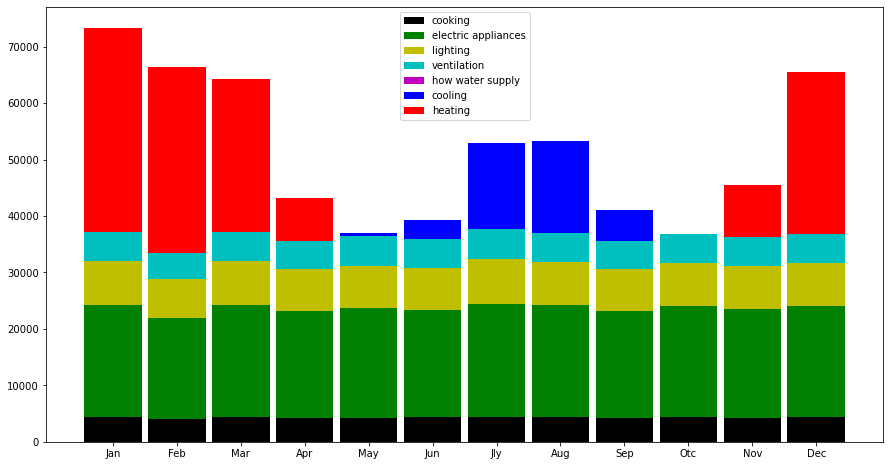

       Jan    Feb    Mar    Apr    May    Jun    Jly    Aug    Sep    Otc  \
暖房   36144  32968  27058   7510      0      0      0      0      0      0   
冷房       0      0      0      0    571   3485  15281  16218   5460      0   
給湯       0      0      0      0      0      0      0      0      0      0   
換気    5216   4709   5216   5039   5199   5046   5220   5214   5039   5208   
照明    7726   6928   7726   7374   7497   7401   7901   7638   7374   7611   
家電   19842  17858  19842  19067  19542  19108  20058  19734  19067  19692   
調理    4454   4000   4454   4166   4188   4310   4437   4464   4166   4322   
分解前   7519   6810   6588   4422   3791   4032   5420   5458   4212   3774   

       Nov    Dec  
暖房    9248  28606  
冷房       0      0  
給湯       0      0  
換気    5050   5208  
照明    7576   7611  
家電   19324  19692  
調理    4291   4322  
分解前   4661   6705  


In [6]:
analysis_and_plot({
    'general' : {
        'region': 6,
        'number_of_people': 4,
        'main_habitable_room_floor_area': 29.81,
        'other_habitable_room_floor_area': 54.34,
        'total_floor_area': 120.08,
        'electric_use': True,
        'gas_use': False,
        'kerosene_use': False
    },
    'electricity': {
        'consumption': [7519, 6810, 6588, 4422, 3791, 4032, 5420, 5458, 4212, 3774, 4661, 6705], 
        'heating': {
            'use': [True, True, True, True, False, False, False, False, False, False, True, True]
        },
        'cooling': {
            'use': [False, False, False, False, True, True, True, True, True, False, False, False]
        },
        'ventilation': {'use': True, 'coeff': 1.0},
        'hot_water_supply': {'use': False},
        'lighting': {'use': True, 'coeff': 1.0},
        'electric_appliance': {'use': True, 'coeff': 1.0},
        'cooking': {'use': True, 'coeff': 1.0}
    }
})

全用途に電力を使用する場合

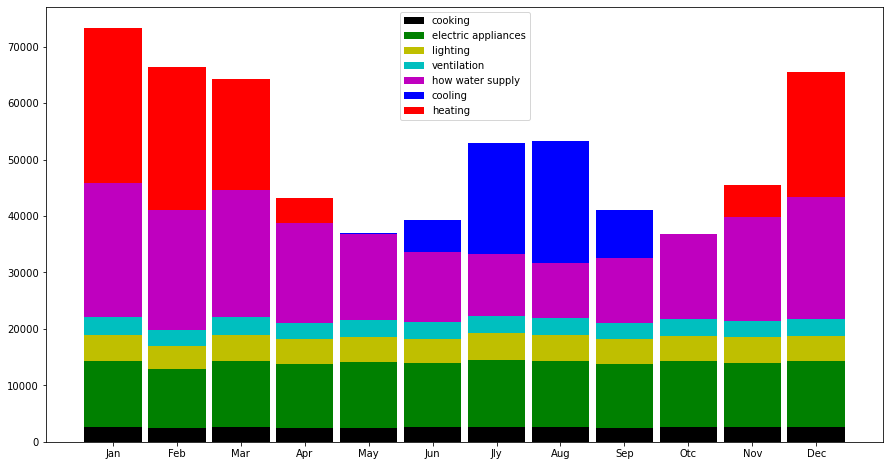

       Jan    Feb    Mar    Apr    May    Jun    Jly    Aug    Sep    Otc  \
暖房   27556  25356  19686   4441      0      0      0      0      0      0   
冷房       0      0      0      0    202   5711  19681  21669   8599      0   
給湯   23760  21258  22543  17592  15210  12386  10925   9643  11384  15006   
換気    3091   2790   3091   2986   3081   2990   3093   3090   2986   3086   
照明    4578   4105   4578   4370   4443   4386   4682   4526   4370   4510   
家電   11758  10582  11758  11299  11580  11323  11886  11694  11299  11669   
調理    2639   2370   2639   2469   2482   2554   2629   2645   2469   2561   
分解前   7519   6810   6588   4422   3791   4032   5420   5458   4212   3774   

       Nov    Dec  
暖房    5625  22119  
冷房       0      0  
給湯   18388  21493  
換気    2992   3086  
照明    4489   4510  
家電   11451  11669  
調理    2543   2561  
分解前   4661   6705  


In [7]:
analysis_and_plot({
    'general' : {
        'region': 6,
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'electric_use': True,
        'gas_use': False,
        'kerosene_use': False
    },
    'electricity': {
        'consumption' : [7519, 6810, 6588, 4422, 3791, 4032, 5420, 5458, 4212, 3774, 4661, 6705], 
        'heating' : {
            'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
        },
        'cooling' : {
            'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
        },
        'ventilation' : { 'use' : True, 'coeff' : 1.0 },
        'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
        'lighting' : { 'use' : True, 'coeff' : 1.0 },
        'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
        'cooking' : { 'use' : True, 'coeff' : 1.0 }
    }
})

暖房・給湯・調理にガスを使用する場合

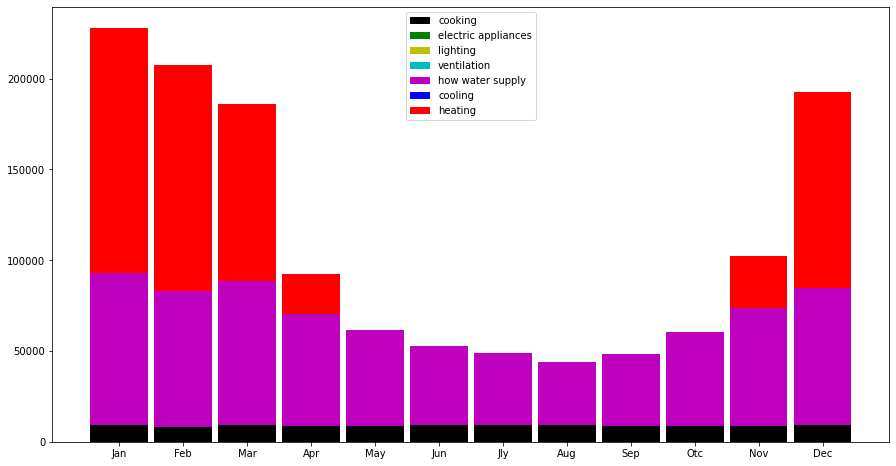

        Jan     Feb    Mar    Apr    May    Jun    Jly    Aug    Sep    Otc  \
暖房   135315  124221  97742  21703      0      0      0      0      0      0   
冷房        0       0      0      0      0      0      0      0      0      0   
給湯    83551   74756  79274  61862  53039  43686  39280  34571  39789  51700   
換気        0       0      0      0      0      0      0      0      0      0   
照明        0       0      0      0      0      0      0      0      0      0   
家電        0       0      0      0      0      0      0      0      0      0   
調理     9283    8337   9283   8683   8655   9008   9454   9483   8630   8824   
分解前    5070    4607   4140   2050   1371   1171   1083    979   1076   1345   

       Nov     Dec  
暖房   28768  107875  
冷房       0       0  
給湯   64664   75582  
換気       0       0  
照明       0       0  
家電       0       0  
調理    8942    9006  
分解前   2275    4277  


In [8]:
analysis_and_plot({
    'general' : {
        'region': 6,
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'electric_use': False,
        'gas_use': True,
        'kerosene_use': False
    },
    'gas': {
        'consumption' : [5070, 4607, 4140, 2050, 1371, 1171, 1083, 979, 1076, 1345, 2275, 4277],
        'heating' : {
            'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
        },
        'cooling' : {
            'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
        },
        'ventilation' : { 'use' : False, 'coeff' : 1.0 },
        'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
        'lighting' : { 'use' : False, 'coeff' : 1.0 },
        'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
        'cooking' : { 'use' : True, 'coeff' : 1.0 }
    }
})

暖房・調理にガスを使用する場合

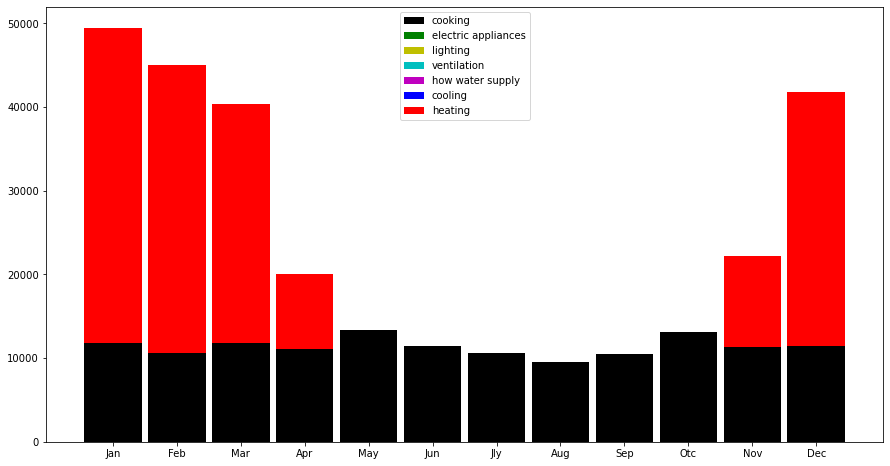

       Jan    Feb    Mar    Apr    May    Jun    Jly   Aug    Sep    Otc  \
暖房   37685  34368  28608   8972      0      0      0     0      0      0   
冷房       0      0      0      0      0      0      0     0      0      0   
給湯       0      0      0      0      0      0      0     0      0      0   
換気       0      0      0      0      0      0      0     0      0      0   
照明       0      0      0      0      0      0      0     0      0      0   
家電       0      0      0      0      0      0      0     0      0      0   
調理   11797  10595  11797  11035  13380  11428  10570  9555  10501  13127   
分解前   5070   4607   4140   2050   1371   1171   1083   979   1076   1345   

       Nov    Dec  
暖房   10838  30296  
冷房       0      0  
給湯       0      0  
換気       0      0  
照明       0      0  
家電       0      0  
調理   11365  11446  
分解前   2275   4277  


In [9]:
analysis_and_plot({
    'general' : {
        'region': 6,
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'electric_use': True,
        'gas_use': False,
        'kerosene_use': False
    },
    'electricity': {
        'consumption' : [5070, 4607, 4140, 2050, 1371, 1171, 1083, 979, 1076, 1345, 2275, 4277],
        'heating' : {
            'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
        },
        'cooling' : {
            'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
        },
        'ventilation' : { 'use' : False, 'coeff' : 1.0 },
        'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
        'lighting' : { 'use' : False, 'coeff' : 1.0 },
        'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
        'cooking' : { 'use' : True, 'coeff' : 1.0 }
    }
})

暖房・給湯に石油を使用する場合

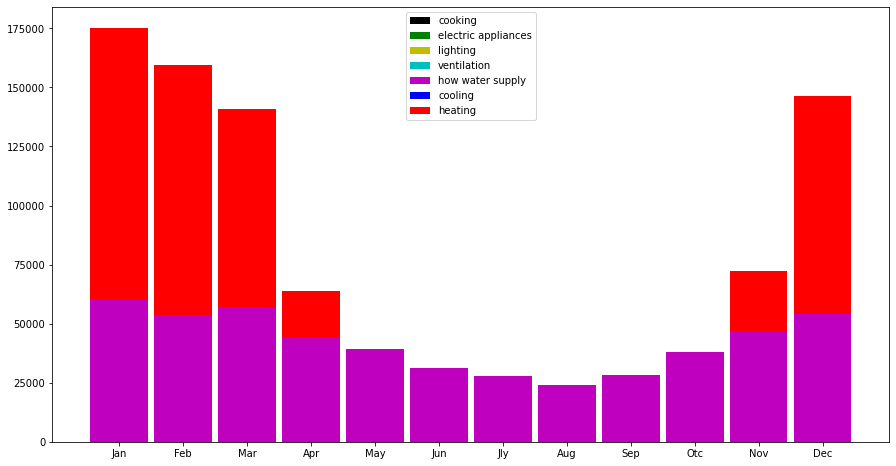

        Jan     Feb    Mar    Apr    May    Jun    Jly    Aug    Sep    Otc  \
暖房   115276  105685  83902  19525      0      0      0      0      0      0   
冷房        0       0      0      0      0      0      0      0      0      0   
給湯    60029   53710  56956  44447  39146  31413  27787  23865  28305  37851   
換気        0       0      0      0      0      0      0      0      0      0   
照明        0       0      0      0      0      0      0      0      0      0   
家電        0       0      0      0      0      0      0      0      0      0   
調理        0       0      0      0      0      0      0      0      0      0   
分解前    4738    4308   3807   1729   1058    849    751    645    765   1023   

       Nov    Dec  
暖房   25838  92030  
冷房       0      0  
給湯   46459  54304  
換気       0      0  
照明       0      0  
家電       0      0  
調理       0      0  
分解前   1954   3955  


In [10]:
analysis_and_plot({
    'general' : {
        'region': 6,
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'electric_use': False,
        'gas_use': False,
        'kerosene_use': True
    },
    'kerosene': {
        'consumption' : [4738, 4308, 3807, 1729, 1058, 849, 751, 645, 765, 1023, 1954, 3955],
        'heating' : {
            'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
        },
        'cooling' : {
            'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
        },
        'ventilation' : { 'use' : False, 'coeff' : 1.0 },
        'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
        'lighting' : { 'use' : False, 'coeff' : 1.0 },
        'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
        'cooking' : { 'use' : False, 'coeff' : 1.0 }
    }
})

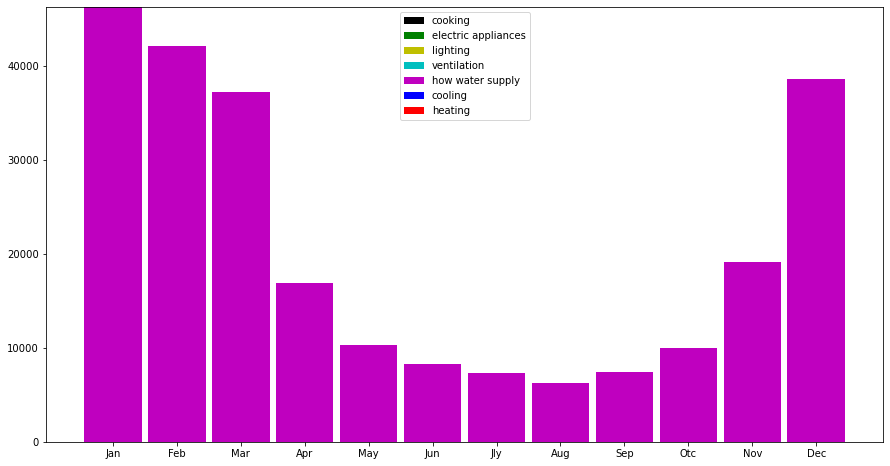

       Jan    Feb    Mar    Apr    May   Jun   Jly   Aug   Sep   Otc    Nov  \
暖房       0      0      0      0      0     0     0     0     0     0      0   
冷房       0      0      0      0      0     0     0     0     0     0      0   
給湯   46242  42046  37156  16875  10326  8286  7329  6295  7466  9984  19071   
換気       0      0      0      0      0     0     0     0     0     0      0   
照明       0      0      0      0      0     0     0     0     0     0      0   
家電       0      0      0      0      0     0     0     0     0     0      0   
調理       0      0      0      0      0     0     0     0     0     0      0   
分解前   4738   4308   3807   1729   1058   849   751   645   765  1023   1954   

       Dec  
暖房       0  
冷房       0  
給湯   38600  
換気       0  
照明       0  
家電       0  
調理       0  
分解前   3955  


In [11]:
analysis_and_plot({
    'general' : {
        'region': 6,
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'electric_use': True,
        'gas_use': False,
        'kerosene_use': False
    },
    'electricity': {
        'consumption' : [4738, 4308, 3807, 1729, 1058, 849, 751, 645, 765, 1023, 1954, 3955],
        'heating' : {
            'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
        },
        'cooling' : {
            'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
        },
        'ventilation' : { 'use' : False, 'coeff' : 1.0 },
        'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
        'lighting' : { 'use' : False, 'coeff' : 1.0 },
        'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
        'cooking' : { 'use' : False, 'coeff' : 1.0 }
    }
})